## Vincent T. Cooper ##
#### Start: 13 May 2021 ##
In this notebook, I preprocess results from the updated version of the coupled wave-ice model.
The goal is to get the data into the same format as the past version, so that I can:  
1 Run the distance-from-ice-edge calculation on new model results, and  
2 Repeat the past analysis outputs, which require the distance grouping.

In [16]:
import numpy as np
import os
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# from matplotlib.colors import DivergingNorm
# import matplotlib.patches as patches
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns; sns.set(color_codes=False)
import cmocean
# from windrose import WindroseAxes

import cftime
import datetime


plt.rcParams['xtick.bottom'] = True # keep my tick marks
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["font.family"] = "Arial"
# plt.rcParams['figure.figsize'] = 12,8
# mpl.rcParams['figure.dpi'] = 300 # activate for presentation quality

from sklearn.metrics.pairwise import haversine_distances

## this is a dummy grid that has the right conventions
grid = xr.open_dataset(
    '/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

## circle boundary for plotting
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

/glade/work/vcooper/npl_clone02/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [12]:
##### MODEL DATA #####
mdir = '/glade/work/lettier/CICE/cicefsdww3i_output_concat/' ## location of file before changing dim names
mdir_adj = '/glade/u/home/vcooper/work/BGEP_vtc/adjfiles/' # location of adjusted files, changed dims to lat and lon
timeslice1719 = slice('2017-01-01','2019-12-31')
latslice = slice(300,384)

## output from distance calculation, using wavewatch data originally
dist_model = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/model_iceedgedistance_2000-2019.nc') 

## keep cice 2018 output because of detailed grid
cice18 = xr.open_dataset(mdir_adj + 'cicefsdww3i.cice.h1.0086.nc') # 2018 rerun
cice18.TLAT[:] = grid.lat # hack to fix polar stereo
cice18.TLON[:] = grid.lon
tarea = cice18.tarea.rename(
    {'TLON':'longitude','TLAT':'latitude'}).reset_coords(names=['ULON','ULAT'],drop=True)

## wavewatch output
ww1719ef = xr.open_dataset(mdir_adj + 'ww3.2017-2019_ef.nc').set_coords(['longitude','latitude'])

## wavewatch results excl. spectra
ww0019 = xr.open_dataset(
    '/glade/work/vcooper/BGEP_vtc/cicefsdww3i.ww3.sigheight.2000-2019.nc').set_coords(
    ['longitude','latitude']) # 6 hourly
xr.merge([ww0019,tarea],compat='override') # disagreements on latitude fill values, seems to be no factor

## revised mask for beaufort (post AGU poster)
latmin = 72
latmax = 79
lonmin = 195
lonmax = 230
beau_mask = (
    (dist_model.coords['longitude'] > lonmin) 
    & (dist_model.coords['longitude'] < lonmax)
    & (dist_model.coords['latitude'] > latmin)
    & (dist_model.coords['latitude'] < latmax)
)

## wavewatch spectra, only have '17-'19
ww1719beau = ww0019.sel(time=timeslice1719,nj=latslice)
ww1719beau.coords['mask'] = (('nj','ni'), beau_mask)
dist_model.coords['mask'] = (('nj','ni'), beau_mask)

dist1719beau = dist_model.sel(time=timeslice1719)
dist1719beau = dist1719beau.where(dist1719beau.mask > 0, drop=True)

ww1719beau_cat = xr.open_dataset('./ww1719beau_cat.nc')
ww1719beau_cat = ww1719beau_cat.where((
    ww1719beau_cat.longitude > lonmin) 
    & (ww1719beau_cat.longitude < lonmax)
    & (ww1719beau_cat.latitude > latmin)
    & (ww1719beau_cat.latitude < latmax),
    drop=True)

ww1719ef_beau_cat = xr.open_dataset('./ww1719ef_beau_cat.nc')
ww1719ef_beau_cat = ww1719ef_beau_cat.where((
    ww1719ef_beau_cat.longitude > lonmin) 
    & (ww1719ef_beau_cat.longitude < lonmax)
    & (ww1719ef_beau_cat.latitude > latmin)
    & (ww1719ef_beau_cat.latitude < latmax),
    drop=True)

ww1719beau_cat['dist'] = dist1719beau

######################

##### SATELLITE OBS from NSIDC, regridded to match CICE grid #####
path = '/glade/work/vcooper/BGEP_vtc/regrid_sat/' ## location of regridded file
ice_file = 'seaice_conc_daily_nh_1979-2019_cicegrid.nc' # name of regridded file
ice_file_originalgrid = 'seaice_conc_daily_nh_1979-2019.nc' # name of original file
boot = (xr.open_dataset(path+ice_file)).rename_vars(seaice_conc_cdr='aice_d')
# boot_native = (xr.open_dataset(path+ice_file_originalgrid)).rename_vars(seaice_conc_cdr='aice_d')

## pre-calculated distance from ice edge for satellite data
dist_sat = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_2012-2019.nc').rename('cdr').to_dataset()
dist_sat_bt = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_bt_2012-2019.nc').rename('bt').to_dataset()
dist_sat_nt = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_nt_2012-2019.nc').rename('nt').to_dataset()
dist_sat_all = xr.merge([dist_sat,dist_sat_bt,dist_sat_nt],)

## fix grid
dist_sat_all.TLON[:] = ww0019.sel(nj=latslice).longitude.values
dist_sat_all.TLAT[:] = ww0019.sel(nj=latslice).latitude.values

#############################################################


##### IN SITU OBSERVATIONS #####
## read in new mooring data revised by Jim Thomson Sep 2020
BGOS_dir = '/glade/work/vcooper/BGEP_vtc/BGOS-AWAC_resultsv02/'
bgosA = xr.open_dataset(BGOS_dir + 'BGOS-A_AWAC.mat_converted.nc')
bgosD = xr.open_dataset(BGOS_dir + 'BGOS-D_AWAC.mat_converted.nc')

## read in latest SODA data on waves
sodaA = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_A_sigWaves.mat_converted_2020-07-27.nc')
sodaB = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_B_sigWaves.mat_converted_2020-07-27.nc')
sodaC = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_C_sigWaves.mat_converted_2020-07-27.nc')

## SWIFT buoys
swiftpath = '/glade/work/lettier/SWIFT_SeaState2015/'
swift_files = ('SWIFT13_11-14Oct2015_30min_converted.nc','SWIFT11_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT09_06-08Oct2015_30min_converted.nc','SWIFT15_23-25Oct2015_30min_converted.nc',
              'SWIFT12_02Oct2015_30min_converted.nc','SWIFT11_23-24Oct2015_30min_converted.nc',
              'SWIFT09_11-14Oct2015_30min_converted.nc','SWIFT11_10Oct2015_30min_converted.nc',
              'SWIFT14_23-24Oct2015_30min_converted.nc','SWIFT09_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT12_23-24Oct2015_30min_converted.nc','SWIFT15_11-13Oct2015_30min_converted.nc',
              'SWIFT14_10Oct2015_30min_converted.nc','SWIFT09_02Nov2015_30min_converted.nc',
              'SWIFT14_04Oct2015_30min_converted.nc','SWIFT13_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT14_11-13Oct2015_30min_converted.nc','SWIFT13_23-24Oct2015_30min_converted.nc',
              'SWIFT14_16-18Oct2015_30min_converted.nc','SWIFT15_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT11_16-18Oct2015_30min_converted.nc','SWIFT11_11-14Oct2015_30min_converted.nc',
              'SWIFT09_23-24Oct2015_30min_converted.nc','SWIFT11_04Oct2015_30min_converted.nc',
              'SWIFT12_11-14Oct2015_30min_converted.nc','SWIFT12_04Oct2015_30min_converted.nc',
              'SWIFT12_06-08Oct2015_30min_converted.nc')

swift_files = sorted(swift_files)  # sorted list of all SWIFT files
swift_names = swift_files # initialize list of shortened names for use as xarray data
swift_dict = {}
nswift = len(swift_names)

for i, file in enumerate(swift_files):
    swift_names[i] = file[:-19] # drops final 19 chars
    swift_dict[swift_names[i]] = xr.open_dataset(swiftpath + file) # datasets for each file, key to swift_names

swift_dist = {} # new dictionary to hold distances for swifts
swift_dist_bt = {} 
swift_dist_nt = {} 

## shortcut dictionary to index grid cells of in situ obs
nj = {}
nj['bds12'] = 349
nj['bds15'] = 350
nj['bds17'] = 349
nj['bds18'] = 349
nj['bgosA'] = 349
nj['bgosD'] = 350
nj['sodaA'] = 347
nj['sodaB'] = 351
nj['sodaC'] = 356

ni = {}
ni['bds12'] = 206
ni['bds15'] = 214
ni['bds17'] = 206
ni['bds18'] = 206
ni['bgosA'] = 206
ni['bgosD'] = 214
ni['sodaA'] = 209
ni['sodaB'] = 208
ni['sodaC'] = 207

for key,da in swift_dict.items():
    
    ## code to find model grid cell closest to lat lon of obs
    templat = np.tile(da.lat.values.mean(),
                  cice18.TLAT.values.size).reshape(cice18.TLAT.values.shape)
    templon = np.tile(da.lon.values.mean(),
                      cice18.TLON.values.size).reshape(cice18.TLON.values.shape) + 360
    difflat = templat - cice18.TLAT.values
    difflon = templon - cice18.TLON.values
    dist = difflat**2 + difflon**2
    njtemp = np.where(dist == np.min(dist))[0][0]
    nitemp = np.where(dist == np.min(dist))[1][0]
    nj[key] = njtemp
    ni[key] = nitemp

################################

In [15]:
###### Coupled Model Update May 2021 #####
hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
day = '01'; hour = '00000'
f1 = 'cesm23iws1tsks.ww3.hi.2012-01-' + day + '-' + hour + '.nc'

days = ['01','02','03']

fpaths = []
for d in days:
    f = hourly_path + 'cesm23iws1tsks.ww3.hi.2012-01-' + d + '-' + hour + '.nc'
    fpaths.append(f)
fpaths

ww2012 = xr.open_mfdataset(fpaths,concat_dim='time')
ww2012
##########################################

/glade/work/vcooper/npl_clone02/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/glade/work/vcooper/npl_clone02/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


<xarray.Dataset>
Dimensions:  (FREQ: 25, NX: 320, NY: 384, time: 3)
Dimensions without coordinates: FREQ, NX, NY, time
Data variables:
    UAX      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    UAY      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    ICE      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    HS       (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T02      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T0M1     (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T01      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    FP0      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    THM      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    EF       (time, FREQ, NY, NX) float32 dask.array<chunksize=(1, 25, 384, 320), meta=np.ndarray>

In [42]:
## add latitude and longitude coords
# ww2012['latitude'] = (['NY','NX'],grid.lat.values)
# ww2012['longitude'] = (['NY','NX'],grid.lon.values)
ww2012 = ww2012.set_coords(['latitude','longitude'])
ww2012

<xarray.Dataset>
Dimensions:    (FREQ: 25, NX: 320, NY: 384, time: 3)
Coordinates:
    latitude   (NY, NX) float64 -79.22 -79.22 -79.22 ... 9.969e+36 9.969e+36
    longitude  (NY, NX) float64 320.6 321.7 322.8 ... 9.969e+36 9.969e+36
Dimensions without coordinates: FREQ, NX, NY, time
Data variables:
    UAX        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    UAY        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    ICE        (time, NY, NX) float32 nan nan nan nan nan ... nan nan nan nan
    HS         (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T02        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T0M1       (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T01        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    FP0        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    THM        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    EF         (time, FREQ, NY, NX) float32 dask.array<chunksize=(1, 25, 384, 320), meta=np.ndarray>

In [47]:
tempd = icedistance(ww2012.ICE[0])
tempd

/glade/work/vcooper/npl_clone02/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/work/vcooper/npl_clone02/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [973.1883 , 952.2485 , 931.84344, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)

In [45]:
## Updated version to 15% ice concentration threshold
def icedistance(iceconc_input):
    # turn icefracs to numpy array
    icefracsnp = iceconc_input.values
#     lats = iceconc_input.TLAT.values
#     lons = iceconc_input.TLON.values
    lats = iceconc_input.latitude.values # wavewatch version
    lons = iceconc_input.longitude.values # wavewatch version


    # create array to hold the distances
    distances = icefracsnp.copy() # same size array as the evaluated data
    distances -= distances # make zeros or nan; we will keep these values for cells that don't need a calc

    
    ##### GET OPEN WATER -> WATER/ICE EDGE LOCATIONS #####
    
    # get all open water locations except at edge of domain to avoid computation breaking
    icefracsnp_noborder = icefracsnp[1:-1,1:-1] # exclude borders for open water checking neighbors
    locations_openw = np.transpose(np.where(icefracsnp_noborder<0.15))
    locations_openw += 1 # adjust indices for the border exclusion

    # create 4 arrays, each represents the offset of open water location in coords by 1 unit
    latp1 = np.append(locations_openw[:,0]+1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    latm1 = np.append(locations_openw[:,0]-1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    lonp1 = np.append(locations_openw[:,0],locations_openw[:,1]+1).reshape(locations_openw.shape,order='F')
    lonm1 = np.append(locations_openw[:,0],locations_openw[:,1]-1).reshape(locations_openw.shape,order='F')

    # get max icefrac of 4 neighbor cells at each open water cell
    iceneighbormax = np.nanmax(np.stack((icefracsnp[latp1[:,0],latp1[:,1]],
                                         icefracsnp[lonm1[:,0],lonm1[:,1]],
                                         icefracsnp[lonp1[:,0],lonp1[:,1]],
                                         icefracsnp[latm1[:,0],latm1[:,1]])),axis=0)

    # get index of the open water cells with ice neighbor>15% # these are values for which we will calc distance
    wateredge = locations_openw[np.where(iceneighbormax>0.15)]
    wateredgeT = wateredge.T
    wateredgelatlon = np.array([[lats[wateredgeT[0],wateredgeT[1]]],
                                [lons[wateredgeT[0],wateredgeT[1]]]]).squeeze().T # Nx2 matrix of lat,lon
    
    ##### CALCULATION OF DISTANCES #####
    
    # get all cell locations with ice > 15%
    icewhere = np.where(icefracsnp>0.15)
    icecells = np.transpose(icewhere) # index by array position
    icelatlon = np.array([[lats[icewhere]],
                          [lons[icewhere]]]).squeeze().T # Nx2 matrix of lat,lon

    # calculate minimum distance
    mindist = haversine_distances(np.deg2rad(icelatlon),
                                  np.deg2rad(wateredgelatlon)).min(axis=1)*6371000/1000 # x by Radius-earth for km
    
    icecellsT = np.transpose(icecells) # transpose for vectorized indexing
    distances[icecellsT[0],icecellsT[1]] = mindist # put mindist into each grid point
    
#     consider adding something like this and removing the loop? so it outputs xarray
#     dist_series = iceconc_input.copy()
#     dist_series.values = np.array(disttest_v04)


    return(distances)

In [72]:
coupled_model_ww1 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-00000.nc')
coupled_model_ww2 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-03600.nc')
coupled_model_ww3 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-07200.nc')
coupled_model_ww4 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-10800.nc')
coupled_model_ww5 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-14400.nc')
coupled_model_ww6 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-18000.nc')


TypeError: concat() missing 1 required positional argument: 'dim'

In [73]:
coupled_model_ww = xr.concat([coupled_model_ww1, 
                             coupled_model_ww2, 
                             coupled_model_ww3, 
                             coupled_model_ww4, 
                             coupled_model_ww5, 
                             coupled_model_ww6],dim='time')

In [75]:
coupled_model_ww_mean = coupled_model_ww.mean(dim='time')

/glade/work/vcooper/npl_clone02/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [4]:
coupled_model_cice = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.cice.h1.2002-11-01.nc')
coupled_model_cice

<xarray.Dataset>
Dimensions:        (d2: 2, nc: 5, ni: 320, nj: 384, nkbio: 5, nkfsd: 12, nkice: 8, nksnow: 3, nvertices: 4, time: 1)
Coordinates:
  * time           (time) object 2002-11-02 00:00:00
    TLON           (nj, ni) float32 ...
    TLAT           (nj, ni) float32 ...
    ULON           (nj, ni) float32 ...
    ULAT           (nj, ni) float32 ...
    NCAT           (nc) float32 ...
    NFSD           (nkfsd) float32 ...
Dimensions without coordinates: d2, nc, ni, nj, nkbio, nkfsd, nkice, nksnow, nvertices
Data variables:
    time_bounds    (time, d2) object ...
    VGRDi          (nkice) float32 ...
    VGRDs          (nksnow) float32 ...
    VGRDb          (nkbio) float32 ...
    tmask          (nj, ni) float32 ...
    tarea          (nj, ni) float32 ...
    uarea          (nj, ni) float32 ...
    dxt            (nj, ni) float32 ...
    dyt            (nj, ni) float32 ...
    dxu            (nj, ni) float32 ...
    dyu            (nj, ni) float32 ...
    HTN            (nj, ni) float32 ...
    HTE            (nj, ni) float32 ...
    ANGLE          (nj, ni) float32 ...
    ANGLET         (nj, ni) float32 ...
    lont_bounds    (nj, ni, nvertices) float32 ...
    latt_bounds    (nj, ni, nvertices) float32 ...
    lonu_bounds    (nj, ni, nvertices) float32 ...
    latu_bounds    (nj, ni, nvertices) float32 ...
    wave_ef_d      (time, nj, ni) float32 ...
    wave_sig_ht_d  (time, nj, ni) float32 ...
    fsdrad_d       (time, nj, ni) float32 ...
    fsdperim_d     (time, nj, ni) float32 ...
    hi_d           (time, nj, ni) float32 ...
    hs_d           (time, nj, ni) float32 ...
    aice_d         (time, nj, ni) float32 ...
    uvel_d         (time, nj, ni) float32 ...
    vvel_d         (time, nj, ni) float32 ...
    uatm_d         (time, nj, ni) float32 ...
    vatm_d         (time, nj, ni) float32 ...
    fswdn_d        (time, nj, ni) float32 ...
    sst_d          (time, nj, ni) float32 ...
    uocn_d         (time, nj, ni) float32 ...
    vocn_d         (time, nj, ni) float32 ...
    frzmlt_d       (time, nj, ni) float32 ...
    fswabs_d       (time, nj, ni) float32 ...
    congel_d       (time, nj, ni) float32 ...
    frazil_d       (time, nj, ni) float32 ...
    meltt_d        (time, nj, ni) float32 ...
    melts_d        (time, nj, ni) float32 ...
    meltb_d        (time, nj, ni) float32 ...
    meltl_d        (time, nj, ni) float32 ...
    fswthru_d      (time, nj, ni) float32 ...
    strwavx_d      (time, nj, ni) float32 ...
    strwavy_d      (time, nj, ni) float32 ...
    strairx_d      (time, nj, ni) float32 ...
    strairy_d      (time, nj, ni) float32 ...
    strtltx_d      (time, nj, ni) float32 ...
    strtlty_d      (time, nj, ni) float32 ...
    strcorx_d      (time, nj, ni) float32 ...
    strcory_d      (time, nj, ni) float32 ...
    strocnx_d      (time, nj, ni) float32 ...
    strocny_d      (time, nj, ni) float32 ...
    dvidtt_d       (time, nj, ni) float32 ...
    dvidtd_d       (time, nj, ni) float32 ...
    daidtt_d       (time, nj, ni) float32 ...
    daidtd_d       (time, nj, ni) float32 ...
    dardg1dt_d     (time, nj, ni) float32 ...
    dardg2dt_d     (time, nj, ni) float32 ...
    opening_d      (time, nj, ni) float32 ...
    apond_ai_d     (time, nj, ni) float32 ...
    aicen_d        (time, nc, nj, ni) float32 ...
    vicen_d        (time, nc, nj, ni) float32 ...
    vsnon_d        (time, nc, nj, ni) float32 ...
    afsd_d         (time, nkfsd, nj, ni) float32 ...
    dafsd_newi_d   (time, nkfsd, nj, ni) float32 ...
    dafsd_latm_d   (time, nkfsd, nj, ni) float32 ...
    dafsd_weld_d   (time, nkfsd, nj, ni) float32 ...
    dafsd_wave_d   (time, nkfsd, nj, ni) float32 ...
    dafsd_latg_d   (time, nkfsd, nj, ni) float32 ...
Attributes:
    title:             cesm23iws
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  day_1
    model_doi_url:     
    comment:           All years have

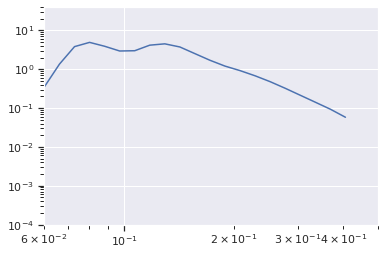

In [68]:
plt.plot(ww1719ef.f.values,coupled_model_ww.EF.sel(NY=nj['sodaB']-100,NX=ni['sodaB']))
plt.loglog()
plt.xlim(0.06,0.5)
plt.ylim(10**-4,4e1)
plt.show()

In [69]:
# ww1719ef.f.values
np.trapz(coupled_model_ww.EF.sel(NY=nj['sodaB']-100,NX=ni['sodaB']),ww1719ef.f.values)**(0.5)*4

2.7579191797820095

In [168]:
coupled_model_ww_mean.HS.sel(NY=nj['sodaB']-30,NX=ni['sodaB']-4)

<xarray.DataArray 'HS' ()>
array(1.4658917, dtype=float32)

In [165]:
coupled_model_ww_mean.HS.sel(NY=nj['sodaB']-10,NX=ni['sodaB']-10)

<xarray.DataArray 'HS' ()>
array(2.3396432, dtype=float32)

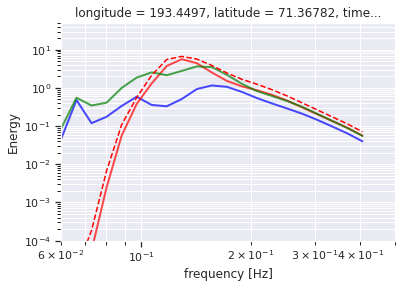

In [206]:
# plt.plot(ww1719ef.f.values,coupled_model_ww_mean.EF.sel(NY=nj['sodaB']-6,NX=ni['sodaB']-4))

# plt.plot(ww1719ef.f.values,coupled_model_ww5.EF.sel(NY=nj['sodaB']-6,NX=ni['sodaB']-4))

# plt.plot(ww1719ef.f.values,coupled_model_ww5.EF.sel(NY=nj['sodaB']-30,NX=ni['sodaB']-4))
plt.plot(ww1719ef.f.values,coupled_model_ww_mean.EF.sel(NY=nj['sodaB']-30,NX=ni['sodaB']-4),c='b',lw=2,alpha=0.7)
# plt.plot(ww1719ef.f.values,coupled_model_ww_mean.EF.sel(NY=nj['sodaB']-200,NX=ni['sodaB']-4))
plt.plot(ww1719ef.f.values,coupled_model_ww_mean.EF.sel(NY=nj['sodaB']-10,NX=ni['sodaB']-10),c='r',lw=2,alpha=0.7)

plt.plot(ww1719ef.f.values,coupled_model_ww_mean.EF.sel(NY=nj['sodaB']-30,NX=ni['sodaB']-15),c='g',lw=2,alpha=0.7)


###
ww1719ef.ef.sel(nj=nj['sodaB']-10,ni=ni['sodaB']-10,time='2018-11-01')[1].plot(c='r',ls='--')
# ww1719ef.ef.sel(nj=nj['sodaB']-10,ni=ni['sodaB']-10,time='2017-11-01')[1].plot(c='k',ls='--')
# ww1719ef.ef.sel(nj=nj['sodaB']-10,ni=ni['sodaB']-10,time='2019-11-01')[1].plot(c='0.5',ls='--')

plt.loglog()
plt.xlim(0.06,0.5)
plt.ylim(10**-4,5e1)
plt.xlabel('frequency [Hz]')
plt.ylabel('Energy')
plt.grid(True,which='both')
plt.show()

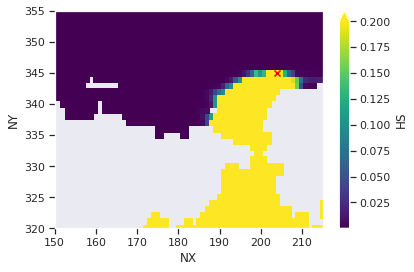

In [121]:
coupled_model_ww_mean.HS.plot(vmax=0.2)
plt.scatter(208-4,nj['sodaB']-6,marker='x',c='r')
plt.xlim(150,215)
plt.ylim(320,355)
# plt.scatter(nj['sodaB']-30, ni['sodaB'],marker='x',c='r',size=10)
plt.show()

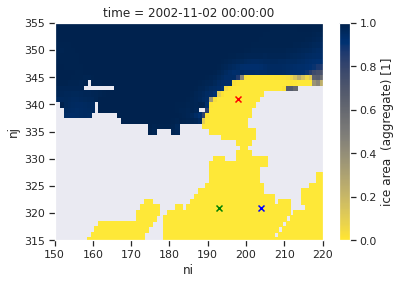

In [188]:
coupled_model_cice.aice_d.plot(cmap='cividis_r')
# plt.scatter(208-4,nj['sodaB']-6,marker='x',c='r')
plt.scatter(208-4,nj['sodaB']-30,marker='x',c='b')
plt.scatter(208-15,nj['sodaB']-30,marker='x',c='g')
plt.scatter(208-10,nj['sodaB']-10,marker='x',c='r')
plt.xlim(150,220)
plt.ylim(315,355)
# plt.scatter(nj['sodaB']-30, ni['sodaB'],marker='x',c='r',size=10)
plt.show()

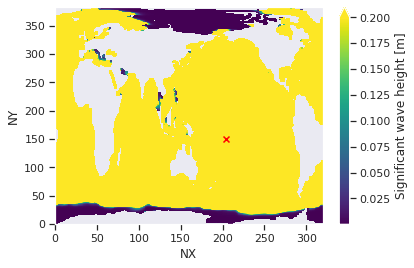

In [152]:
coupled_model_ww5.HS.plot(vmax=0.2)
plt.scatter(208-4,nj['sodaB']-200,marker='x',c='r')
# plt.xlim(150,215)
# plt.ylim(320,355)
# plt.scatter(nj['sodaB']-30, ni['sodaB'],marker='x',c='r',size=10)
plt.show()

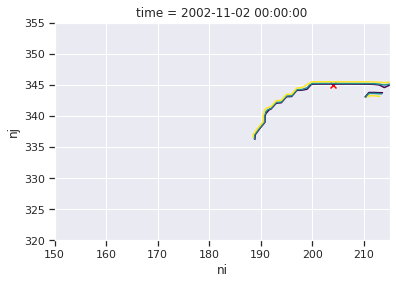

In [135]:
coupled_model_cice.aice_d.squeeze().plot.contour(levels=[0.15,0.25,0.5])
plt.scatter(208-4,nj['sodaB']-6,marker='x',c='r')
plt.xlim(150,215)
plt.ylim(320,355)
# plt.scatter(nj['sodaB']-30, ni['sodaB'],marker='x',c='r',size=10)
plt.show()

In [192]:
ww1719beau

<xarray.Dataset>
Dimensions:    (ni: 320, nj: 84, time: 4380)
Coordinates:
    longitude  (nj, ni) float32 ...
    latitude   (nj, ni) float32 ...
  * time       (time) datetime64[ns] 2017-01-01 ... 2019-12-31T18:00:00
    mask       (nj, ni) bool False False False False ... False False False False
Dimensions without coordinates: ni, nj
Data variables:
    MAPSTA     (nj, ni) int16 ...
    dpt        (time, nj, ni) float32 ...
    uwnd       (time, nj, ni) float32 ...
    vwnd       (time, nj, ni) float32 ...
    ast        (time, nj, ni) float32 ...
    ice        (time, nj, ni) float32 ...
    hs         (time, nj, ni) float32 ...
    lm         (time, nj, ni) float32 ...
    t02        (time, nj, ni) float32 ...
    t0m1       (time, nj, ni) float32 ...
    t01        (time, nj, ni) float32 ...
    fp         (time, nj, ni) float32 ...
    dir        (time, nj, ni) float32 ...
    spr        (time, nj, ni) float32 ...
    dp         (time, nj, ni) float32 ...
Attributes:
    WAVEWATCH_III_version_number:  5.16
    WAVEWATCH_III_switches:        F90 NOGRB NOPA LRB4 NC4 PR3 UQ FLX0 LN1 ST...
    product_name:                  ww3.20000101.nc
    area:                          POP 1 degree grid (gx1v6b)
    latitude_resolution:           n/a
    longitude_resolution:          n/a
    southernmost_latitude:         -79.22052
    northernmost_latitude:         89.70641
    westernmost_longitude:         1.4731102E-02
    easternmost_longitude:         359.9960
    minimum_altitude:              -12000 m
    maximum_altitude:              9000 m
    altitude_resolution:           n/a
    start_date:                    2000-01-01 00:00:00
    stop_date:                     2000-01-01 18:00:00
    nco_openmp_thread_number:      1
    history:                       Fri Jun 26 16:57:55 2020: ncrcat cicefsdww...
    NCO:                           netCDF Operators version 4.7.9 (Homepage =...

In [197]:
ww1719ef.ef.sel(nj=nj['sodaB']-10,ni=ni['sodaB']-10,time='2018-11-01')[0]

<xarray.DataArray 'ef' (f: 25)>
array([5.187822e-10, 1.073148e-08, 2.493404e-07, 1.095380e-06, 7.097297e-06,
       1.620678e-05, 2.465322e-05, 2.660914e-04, 6.146821e-03, 5.159676e-02,
       2.982422e-01, 1.392692e+00, 3.399139e+00, 5.473507e+00, 5.418143e+00,
       3.721037e+00, 2.082450e+00, 1.283081e+00, 9.033954e-01, 6.824722e-01,
       4.821395e-01, 3.221779e-01, 2.079277e-01, 1.352979e-01, 8.400936e-02],
      dtype=float32)
Coordinates:
    longitude  float32 ...
    latitude   float32 ...
  * f          (f) float32 0.04118 0.045298003 ... 0.36873826 0.40561208
    time       datetime64[ns] 2018-11-01
Attributes:
    long_name:      wave_elevation_spectrum
    standard_name:  power_spectral_density_of_surface_elevation
    globwave_name:  power_spectral_density_of_surface_elevation
    units:          m2 s
    valid_min:      -30000
    valid_max:      32000